In [2]:
from Bio import SeqIO
from Bio import motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import click
from click_option_group import optgroup
import gc
import gzip
from io import StringIO
import numpy as np
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
bar_format = "{percentage:3.0f}%|{bar:20}{r_bar}"

In [3]:
from architectures import CAM
from jaspar import get_figure, reformat_jaspar_motif
from sequence import one_hot_encode, rc_one_hot_encoding, rc

In [4]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [5]:
#model_file = "../results/SMS.published/CAM/CTCF.NA@snappy-grey-markhor/best_model.pth.tar"
#training_file = "../results/SMS.published/FASTA/Train/CTCF.NA@snappy-grey-markhor.fa.gz"
#output_dir = "../results/SMS.published/CAM/CTCF.NA@snappy-grey-markhor/"
#tf_name = "SOX2.NA"
#model_file = "../results/Human-Mouse-Project/CAM/best_model.pth.tar"
#training_file = "../results/Human-Mouse-Project/FASTA/train.fa.gz"
#output_dir = "../results/Human-Mouse-Project/CAM/"
#tf_name = "human-mouse"
model_file = "../results/CHS/CAM/ZBED2.FL@hilly-bronze-frise/best_model.pth.tar"
training_file = "../results/CHS/FASTA/Train/ZBED2.FL@hilly-bronze-frise.fa.gz"
output_dir = "../results/CHS/CAM/ZBED2.FL@hilly-bronze-frise/"
tf_name = "ZBED2.FL@hilly-bronze-frise"
batch_size = 2**6
debugging = False
threads = 1

In [6]:
# Create output dirs
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
for subdir in ["sites", "motifs", "logos"]:
    if not os.path.isdir(os.path.join(output_dir, subdir)):
        os.makedirs(os.path.join(output_dir, subdir))

In [7]:
# Load model
selene_dict = torch.load(model_file)
model = CAM(
    selene_dict["options"]["cnn_units"],
    selene_dict["options"]["kernel_size"],
    selene_dict["options"]["sequence_length"],
    selene_dict["options"]["n_features"],
    selene_dict["options"]["clamp_weights"],
    selene_dict["options"]["no_padding"],
    selene_dict["options"]["weights_file"],
)
model.load_state_dict(selene_dict["state_dict"])
model.to(device)

CAM(
  (linears): Sequential(
    (0): Conv1d(64, 16, kernel_size=(19,), stride=(1,), padding=(19,), groups=16)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpAct()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): UnSqueeze()
    (6): Conv1d(496, 1600, kernel_size=(1,), stride=(1,), groups=16)
    (7): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(1600, 16, kernel_size=(1,), stride=(1,), groups=16)
    (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=16, out_features=1, bias=True)
)

In [8]:
# Padding
if selene_dict["options"]["no_padding"]:
    padding = 0
else:
    padding = selene_dict["options"]["kernel_size"]

In [9]:
def _get_Xs_ys_record_ids_sequences(fasta_file, debugging=False, reverse_complement=False):

    # Initialize
    Xs = []
    ys = []
    record_ids = []
    sequences = []

    # Xs / ys
    handle = __get_handle(fasta_file)
    for record in SeqIO.parse(handle, "fasta"):
        _, y_list = record.description.split()
        Xs.append(one_hot_encode(str(record.seq).upper()))
        ys.append([float(y) for y in y_list.split(";")])
        record_ids.append((record.id, "+"))
        sequences.append(str(record.seq))

    # Reverse complement
    if reverse_complement:
        n = len(Xs)
        for i in range(n):
            Xs.append(rc_one_hot_encoding(Xs[i]))
            ys.append(ys[i])
            record_ids.append((record_ids[i][0], "-"))
            sequences.append(rc(sequences[i]))

    # Return 1,000 sequences
    if debugging:
        return(np.array(Xs)[:10000], np.array(ys)[:10000], 
               np.array(record_ids)[:10000])

    return(np.array(Xs), np.array(ys), np.array(record_ids), sequences)

def _get_data_loader(Xs_train, ys_train, batch_size=2**6, threads=1):

    # TensorDatasets
    train_set = TensorDataset(torch.Tensor(Xs_train), torch.Tensor(ys_train))

    # DataLoaders
    kwargs = dict(batch_size=batch_size, num_workers=threads)
    train_loader = DataLoader(train_set, **kwargs)

    return(train_loader)

def __get_handle(file_name):
    if file_name.endswith("gz"):
        handle = gzip.open(file_name, "rt")
    else:
        handle = open(file_name, "rt")
    return(handle)

In [10]:
# Get Xs/ys/record ids
Xs, ys, record_ids, sequences = _get_Xs_ys_record_ids_sequences(training_file, debugging, True)

# Get DataLoader
data_loader = _get_data_loader(list(Xs), list(ys), batch_size, threads)

# Input data
if np.unique(ys[:, 0]).size == 2:
    input_data = "binary"
else:
    input_data = "linear"

# Fix sequences
for i in range(len(sequences)):
    sequences[i] = "N" * padding + sequences[i] + "N" * padding
sequences = np.array(sequences)
sequences

array(['NNNNNNNNNNNNNNNNNNNCGGCAGTCTcctccctccttccctccctccccgactccctccctcccgccttccctctccgctctcctccctccacccgctctccttccccctcccccctccGAACCCGGGCGCAAGGGGGGAATTAGAAACTGCTCTAGAAGGATTTTAAACAACTGGCTGTTCTCTCCGCCGCCACCCCTCCCCCCGCGCCGCCCGCGCNNNNNNNNNNNNNNNNNNN',
       'NNNNNNNNNNNNNNNNNNNTACCGGACCCCACGGAGCAAGTTATTAACGTTGAGACTCGACGCCACTCTCCGCCAGAGCGCTTGCGTCCGGACTCTGACCAAGGGCCGGCCGCGGTACCCTCGGGGGAGAAAGCAACCTGTCGGCTGGTTTACTGCGTCTCACAGCCCCGACCTTCCAGAGGCTGCCCAAGGCGAAGGGGGTTGCCGTCGGTAAGGGTTTNNNNNNNNNNNNNNNNNNN',
       'NNNNNNNNNNNNNNNNNNNGCCCCCGCTCGACCCCGCCGCGGCGACTAGCAAGCTGTGGCCGCCGGAAGCCACGCCCCCGGCGCCTGCCATGACGGAGTCGGGCAATTCCGGGTTCGTGACACTTTCCTCACACCGATCGCGACGGTGGATGGGCCGGCGGCCATCTTAGGTACTGGTAGAGCGACTCATTTCCGGAACGCGGTCTTGGGAGCCGGAAGANNNNNNNNNNNNNNNNNNN',
       ...,
       'NNNNNNNNNNNNNNNNNNNCACCAATCGACTGCACGAACTCCCACCACGCGTCAGAAAGCCTCTCTCACTTTTGGCGGCACGTCCACGCTCACCACACCGACAGCACTCACCGGGGGGCACGCTCACACACTGCACACACGGCACAGCTCGTACCACAGCACTGGTTTCTTCAGACAGCGATCTACGCCGCGCCAGTCTCTGGTTGCAACAGACACACCGNNNNNNNNNN

In [11]:
# Free memory
del Xs
del ys
gc.collect()

20

In [12]:
# Initialize
outputs = []
labels = []

# Get sequences, outputs, and labels
with torch.no_grad():
    for x, label in tqdm(data_loader, total=len(data_loader)):

        # Get outputs
        x = x.to(device)
        out = model(x)
        if input_data == "binary":
            out = torch.sigmoid(out)
        outputs.extend(out.detach().cpu().numpy())

        # Get labels
        labels.extend(label.numpy())

# To NumPy
outputs = np.array(outputs)
labels = np.array(labels)

100%|██████████| 275/275 [00:01<00:00, 168.98it/s]


In [13]:
def __get_activations(model, data_loader, activations):

    # Counter
    idx = 0

    with torch.no_grad():
        for x, _ in tqdm(data_loader, total=len(data_loader)):
            x = x.to(device)
            x = x.repeat(1, model._options["cnn_units"], 1)
            activations[idx:idx+x.shape[0], :, :] = model.linears[:3](x).cpu()
            idx += x.shape[0]           

    return(activations.numpy())

In [14]:
# Get activations
shape = (len(sequences), model._options["cnn_units"], len(sequences[0]) - model._options["kernel_size"] + 1)
activations = __get_activations(model, data_loader, torch.zeros(shape, dtype=torch.float16))
activations

100%|██████████| 275/275 [00:01<00:00, 205.76it/s]


array([[[2.232 , 2.95  , 1.521 , ..., 2.31  , 1.852 , 2.232 ],
        [1.536 , 1.451 , 0.943 , ..., 1.521 , 1.583 , 1.536 ],
        [1.14  , 1.148 , 0.716 , ..., 1.301 , 0.918 , 1.14  ],
        ...,
        [0.8936, 1.15  , 1.162 , ..., 0.813 , 1.011 , 0.8936],
        [1.015 , 1.302 , 1.834 , ..., 0.7437, 0.971 , 1.015 ],
        [2.33  , 2.193 , 2.574 , ..., 1.92  , 1.842 , 2.33  ]],

       [[2.232 , 2.455 , 1.312 , ..., 2.13  , 2.549 , 2.232 ],
        [1.536 , 1.418 , 1.177 , ..., 1.637 , 1.624 , 1.536 ],
        [1.14  , 0.953 , 0.869 , ..., 1.087 , 1.043 , 1.14  ],
        ...,
        [0.8936, 1.162 , 1.099 , ..., 1.006 , 1.1045, 0.8936],
        [1.015 , 1.045 , 1.474 , ..., 0.682 , 0.8237, 1.015 ],
        [2.33  , 1.955 , 2.475 , ..., 2.975 , 2.594 , 2.33  ]],

       [[2.232 , 2.201 , 2.93  , ..., 3.074 , 2.127 , 2.232 ],
        [1.536 , 1.1875, 2.04  , ..., 1.315 , 1.568 , 1.536 ],
        [1.14  , 1.09  , 1.853 , ..., 1.467 , 1.186 , 1.14  ],
        ...,
        [0.8

In [15]:
# Get the indices of well predicted sequences
if input_data == "binary":
    indices = np.where((labels == 1.) & (outputs >= .5))[0]
else:
    labels_ixs = np.argsort(-labels.flatten())[:int(max(labels.shape) * .1)]
    outputs_ixs = np.argsort(-outputs.flatten())[:int(max(outputs.shape) * .1)]
    indices = np.intersect1d(labels_ixs, outputs_ixs)
indices.shape

(7571,)

In [16]:
# Free memory
del labels
del outputs
del data_loader
gc.collect()

143

In [17]:
# For each filter, get the activation thresholds (i.e. ≥50%)
act_thresholds = 0.5 * np.amax(activations[indices, :, :], axis=(0, 2))

In [18]:
def __get_filter_sites(indices, record_ids, sequences, activations,
                       threshold, kernel_size=19):
    """
    For each filter and for each sequence, get sites reaching at least
    ½ of the maximum activation value for that filter.
    """

    # Initialize
    sites = []

    # For each sequence...
    for i in indices:

        # Get start positions of sequence sites activating this filter
        starts = np.where(activations[i, :] > threshold)

        # For each start...
        for j in starts[0]:

            # Get site
            seq = Seq(sequences[i][j:j+kernel_size])
            seq_id = "%s_%s_from=%s_to=%s" % (record_ids[i][0],
                                              record_ids[i][1],
                                              j, j+kernel_size)
            sites.append(SeqRecord(seq, id=seq_id, name="",
                                   description=""))

    return(sites)

In [19]:
# For each filter...
for i in tqdm(range(len(act_thresholds)), total=len(act_thresholds)):

    sites_file = os.path.join(output_dir, "sites", f"filter{i}.fa")
    if not os.path.exists(sites_file):

        # Get sites
        sites = __get_filter_sites(indices, record_ids, sequences,
                                   activations[:, i, :], act_thresholds[i],
                                   model._options["kernel_size"])

        # Save sites
        with open(sites_file, "w") as handle:
            SeqIO.write(sites, handle, "fasta")

100%|██████████| 16/16 [00:00<00:00, 22.81it/s]


In [20]:
def __get_motif_from_sites(sites_file):
    """
    From https://github.com/biopython/biopython/blob/master/Bio/motifs/__init__.py
    Read the motif from JASPAR .sites file.
    """
    alphabet = "ACGTN"
    instances = []
    pfm = {}

    with open(sites_file) as handle:
        for line in handle:
            if not line.startswith(">"):
                break
            # line contains the header ">...."
            # now read the actual sequence
            line = next(handle)
            instance = ""
            for c in line.strip().upper():
                if c == c.upper():
                    instance += c
            instance = Seq(instance)
            instances.append(instance)

    instances = motifs.Instances(instances, alphabet)
    motif = motifs.Motif(alphabet=alphabet, instances=instances)

    for nt in alphabet[:-1]:
        pfm.setdefault(nt, motif.counts[nt])

    return(motifs.Motif(counts=pfm))

In [21]:
# For each filter...
for i in tqdm(range(len(act_thresholds)), total=len(act_thresholds)):

    motif_file = os.path.join(output_dir, "motifs", f"filter{i}.jaspar")
    if not os.path.exists(motif_file):

        # Get motif
        sites_file = os.path.join(output_dir, "sites", f"filter{i}.fa")
        motif = __get_motif_from_sites(sites_file)
        motif.matrix_id = f"filter{i}"
        motif.name = tf_name

        # Save motif
        with open(motif_file, "w") as handle:
            handle.write(format(motif, "jaspar"))

100%|██████████| 16/16 [00:00<00:00, 246.35it/s]


100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


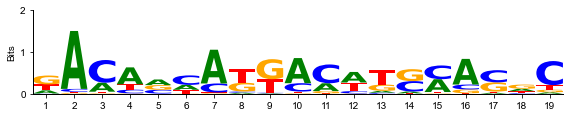

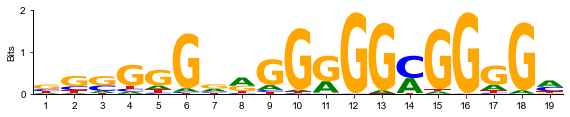

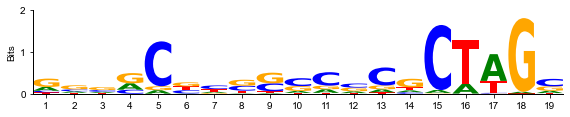

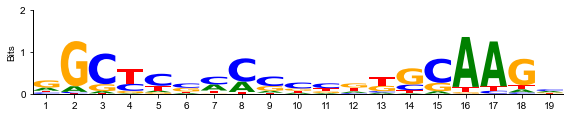

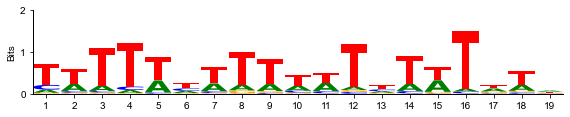

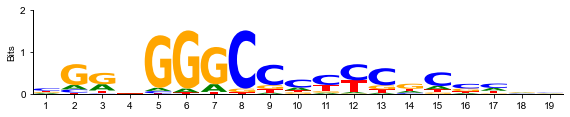

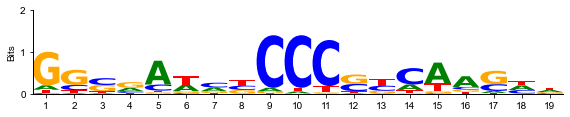

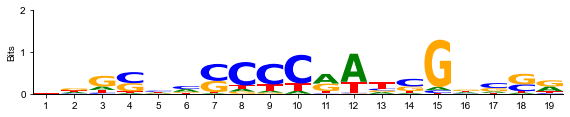

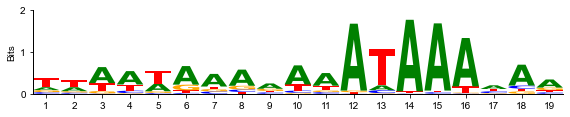

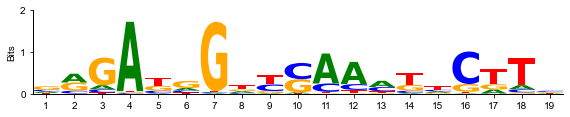

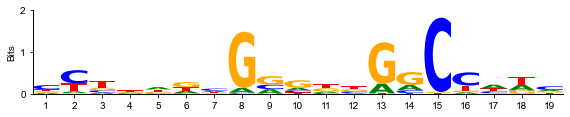

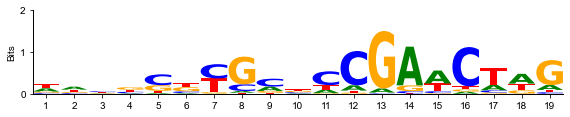

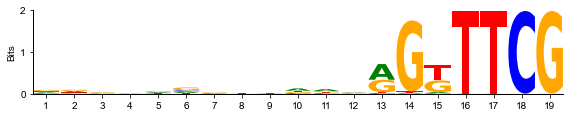

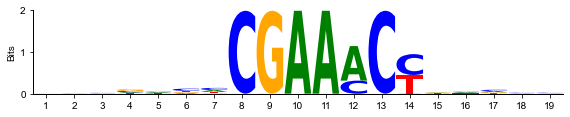

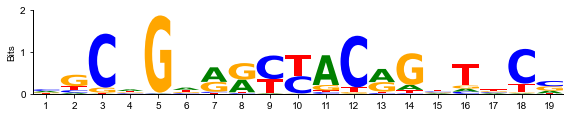

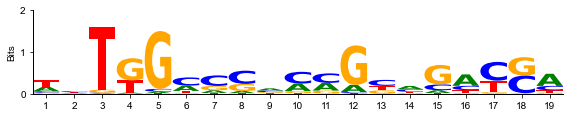

In [22]:
# For each filter...
for i in tqdm(range(len(act_thresholds)), total=len(act_thresholds)):

    logo_file = os.path.join(output_dir, "logos", f"filter{i}.png")
    if not os.path.exists(logo_file):

        # Save logo
        motif_file = os.path.join(output_dir, "motifs", f"filter{i}.jaspar")
        fig = get_figure(motif_file)
        fig.savefig(logo_file, bbox_inches="tight", pad_inches=0)

In [23]:
# Get weights
weights = model.final.weight.detach().cpu().numpy().flatten().tolist()
weights

[0.2779728174209595,
 0.5705921649932861,
 0.45991048216819763,
 -0.34991350769996643,
 0.4525647461414337,
 -0.5606385469436646,
 -0.28398215770721436,
 0.6471378207206726,
 0.4912586808204651,
 0.458416610956192,
 -0.45299267768859863,
 -0.4085617661476135,
 -0.5375611782073975,
 0.6666699647903442,
 0.42663684487342834,
 -0.36597156524658203]

In [24]:
# Save weights
weights_file = os.path.join(output_dir, "filter-weights.tsv")
if not os.path.exists(weights_file):
    with open(weights_file, "w") as handle:
        for i, weight in enumerate(weights):
            handle.write(f"filter{i}\t{weight}\n")